In [1]:
# Pandas library for the pandas dataframes
import pandas as pd    
import numpy as np

# Import Scikit-Learn library for decision tree models
import sklearn         
from sklearn import linear_model, datasets
from sklearn.utils import resample
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import f_regression, SequentialFeatureSelector
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import plot_confusion_matrix


# Import plotting libraries
import matplotlib 
from matplotlib import pyplot as plt


# Set larger fontsize for all plots
matplotlib.rcParams.update({'font.size': 18})
from IPython.display import clear_output

# Command to automatically reload modules before executing cells
# not needed here but might be if you are writing your own library 
%load_ext autoreload
%autoreload 2

# Import cleaning and splitting functions
from clean_split_data import clean_data
from clean_split_data import split_data

# For confusion matrix count
from collections import Counter

### Data

In [2]:
data = pd.read_csv('data.csv')

In [3]:
data = clean_data(data)
X_train, X_test, y_train, y_test = split_data(data)

In [4]:
X_train

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
68,9.029,17.33,58.79,250.5,0.10660,0.14130,0.31300,0.04375,0.2111,0.08046
181,21.090,26.57,142.70,1311.0,0.11410,0.28320,0.24870,0.14960,0.2395,0.07398
63,9.173,13.86,59.20,260.9,0.07721,0.08751,0.05988,0.02180,0.2341,0.06963
248,10.650,25.22,68.01,347.0,0.09657,0.07234,0.02379,0.01615,0.1897,0.06329
60,10.170,14.88,64.55,311.9,0.11340,0.08061,0.01084,0.01290,0.2743,0.06960
...,...,...,...,...,...,...,...,...,...,...
71,8.888,14.64,58.79,244.0,0.09783,0.15310,0.08606,0.02872,0.1902,0.08980
106,11.640,18.33,75.17,412.5,0.11420,0.10170,0.07070,0.03485,0.1801,0.06520
270,14.290,16.82,90.30,632.6,0.06429,0.02675,0.00725,0.00625,0.1508,0.05376
435,13.980,19.62,91.12,599.5,0.10600,0.11330,0.11260,0.06463,0.1669,0.06544


### Classifier

In [5]:
max_depths = [1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 25, 30, 35, 40]
list_mse = []
for depth in max_depths:
    classifier = DecisionTreeClassifier(max_depth=depth, random_state=42)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    list_mse.append(mean_squared_error(y_test, y_pred))

Text(0.5, 1.0, 'MSE at different max_depths')

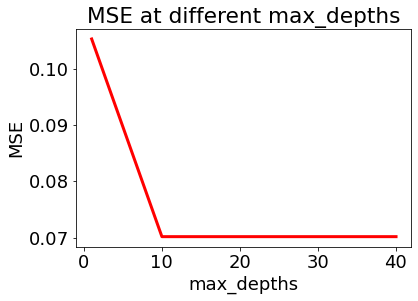

In [6]:
plt.plot(max_depths, list_mse, c='r', linewidth=3)
plt.xlabel('max_depths')
plt.ylabel('MSE')
plt.title('MSE at different max_depths')

Therefore pick max max depth of 13

In [7]:
classifier = DecisionTreeClassifier(max_depth=10)
classifier.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10)

### Decision Tree Prediction (User Input)

In [8]:
def predict(test_data):
    '''
    Takes test data and uses classifier to predict boolean output.
    '''
    y_pred = classifier.predict(test_data)
    
    return y_pred

### Sample Train, Test, Split results

In [9]:
def sample_results():
    ''' 
    Returns the results and confusion matrix of the sample dataset from Breast Cancer Wisconsin Dataset.
    '''
    y_pred = classifier.predict(X_test)
    print("Prediction accuracy MSE: ", mean_squared_error(y_test, y_pred))
    print("Mean accuracy on test set", classifier.score(X_test, y_test))
    print("The confusion matrix for the sample dataset using a decision tree is displayed below: ")
    plot_confusion_matrix(classifier, X_test, y_test)
    plt.show()
    
    return

Prediction accuracy MSE:  0.08771929824561403
Mean accuracy on test set 0.9122807017543859
The confusion matrix for the sample dataset using a decision tree is displayed below: 


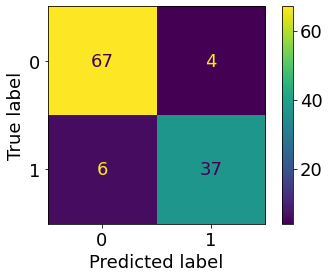

In [10]:
sample_results()

### Backwards Stepwise Slection for Optimizing Input Features

In [11]:
X = data[['radius_mean', 'texture_mean', 'perimeter_mean',
   'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
   'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean']]
y = data.diagnosis

In [12]:
sfs_backward = SequentialFeatureSelector(DecisionTreeClassifier(),
                                     n_features_to_select=(5),
                                     direction='backward').fit(X, y)

In [13]:
input_features_count = [1, 2, 3, 4, 5, 6, 7, 8, 9]

list_test_mse = []
list_test_R2 = []
list_test_accuracy = []

list_training_mse = []
list_training_R2 = []
list_training_accuracy = []

selected_features = []

classifier = DecisionTreeClassifier(max_depth=13)

for count in input_features_count:
    sfs_backward = SequentialFeatureSelector(DecisionTreeClassifier(),
                                         n_features_to_select=(count),
                                         direction='backward').fit(X, y)
    f_names = np.array(X.columns)
    selected = sfs_backward.get_support(indices=True)
    X_selected = data[f_names[selected]]
    selected_features.append(f_names[selected])
    X_train_selected, X_test_selected, y_train_selected, y_test_selected = train_test_split(X_selected, y, test_size=0.2, random_state=42)
    classifier.fit(X_train_selected, y_train_selected)
    
    y_test_pred = classifier.predict(X_test_selected)
    list_test_mse.append(mean_squared_error(y_test_selected, y_test_pred))
    list_test_R2.append(r2_score(y_test_selected, y_test_pred))
    list_test_accuracy.append(accuracy_score(y_test_selected, y_test_pred))
    
    y_train_pred = classifier.predict(X_train_selected)
    list_training_mse.append(mean_squared_error(y_train_selected, y_train_pred))
    list_training_R2.append(r2_score(y_train_selected, y_train_pred))
    list_training_accuracy.append(accuracy_score(y_train_selected, y_train_pred))

<bound method Figure.tight_layout of <Figure size 720x2160 with 3 Axes>>

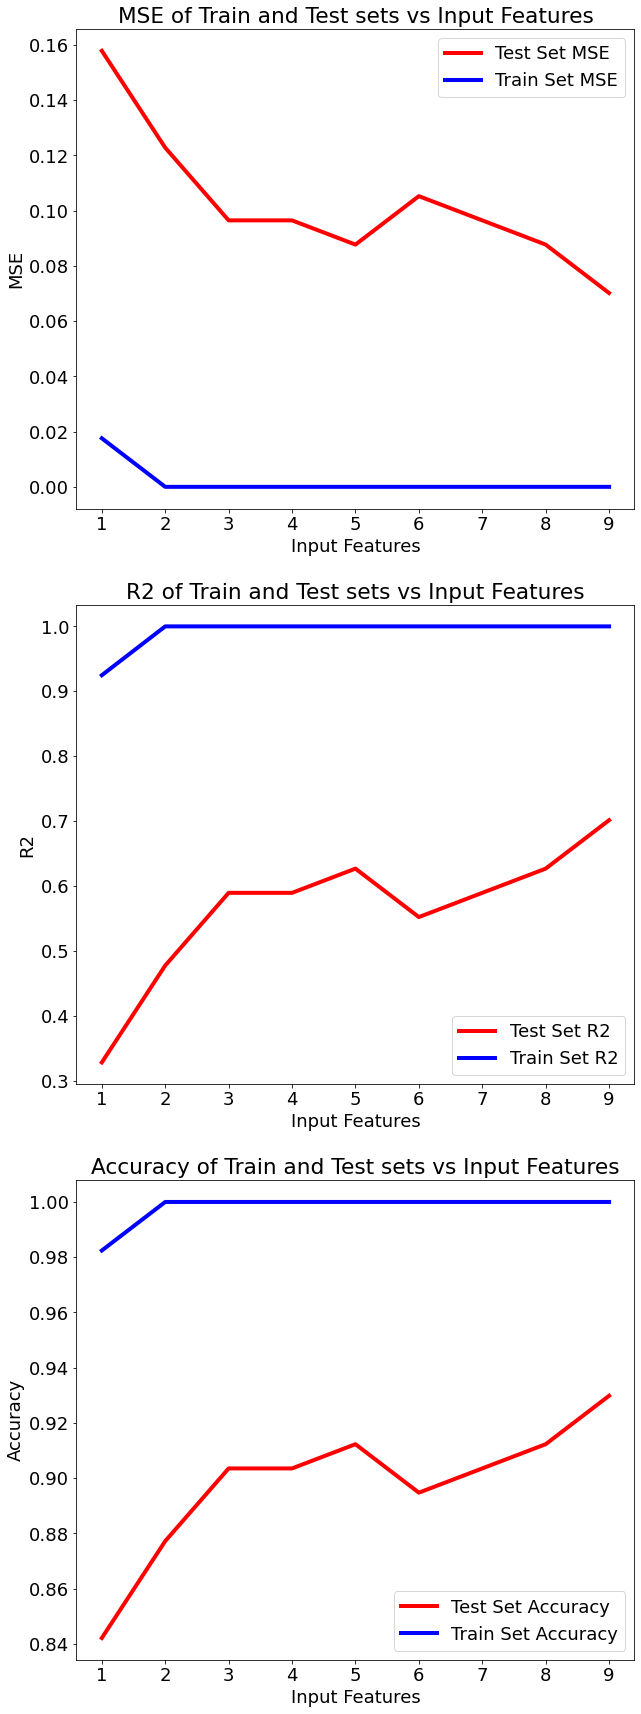

In [14]:
nrows = 3
fig = plt.figure(figsize=(10, nrows * 10))
ax = fig.subplots(nrows=nrows, ncols=1)

ax[0].plot(input_features_count, list_test_mse, label='Test Set MSE', c='r', linewidth=4)
ax[0].plot(input_features_count, list_training_mse, label='Train Set MSE', c='b', linewidth=4)
ax[0].set_xlabel('Input Features')
ax[0].set_ylabel('MSE')
ax[0].set_title('MSE of Train and Test sets vs Input Features')
ax[0].legend()

ax[1].plot(input_features_count, list_test_R2, label='Test Set R2', c='r', linewidth=4)
ax[1].plot(input_features_count, list_training_R2, label='Train Set R2', c='b', linewidth=4)
ax[1].set_xlabel('Input Features')
ax[1].set_ylabel('R2')
ax[1].set_title('R2 of Train and Test sets vs Input Features')
ax[1].legend()

ax[2].plot(input_features_count, list_test_accuracy, label='Test Set Accuracy', c='r', linewidth=4)
ax[2].plot(input_features_count, list_training_accuracy, label='Train Set Accuracy', c='b', linewidth=4)
ax[2].set_xlabel('Input Features')
ax[2].set_ylabel('Accuracy')
ax[2].set_title('Accuracy of Train and Test sets vs Input Features')
ax[2].legend()

fig.tight_layout

In [15]:
selected_features[8]

array(['radius_mean', 'texture_mean', 'area_mean', 'smoothness_mean',
       'compactness_mean', 'concavity_mean', 'concave points_mean',
       'symmetry_mean', 'fractal_dimension_mean'], dtype=object)